<h1 style="text-align: center;">Well Plate Setup With OT2</h1> 

## In this notebook:
1. Run protocol
1. Testing: checking protocol steps and estimate duration (optional)

<h1 style="text-align: center;">Run Protocol</h1> 

### 1. Enter your file name

In [ ]:
filename = 'OT_Template.xlsx'

Example file:
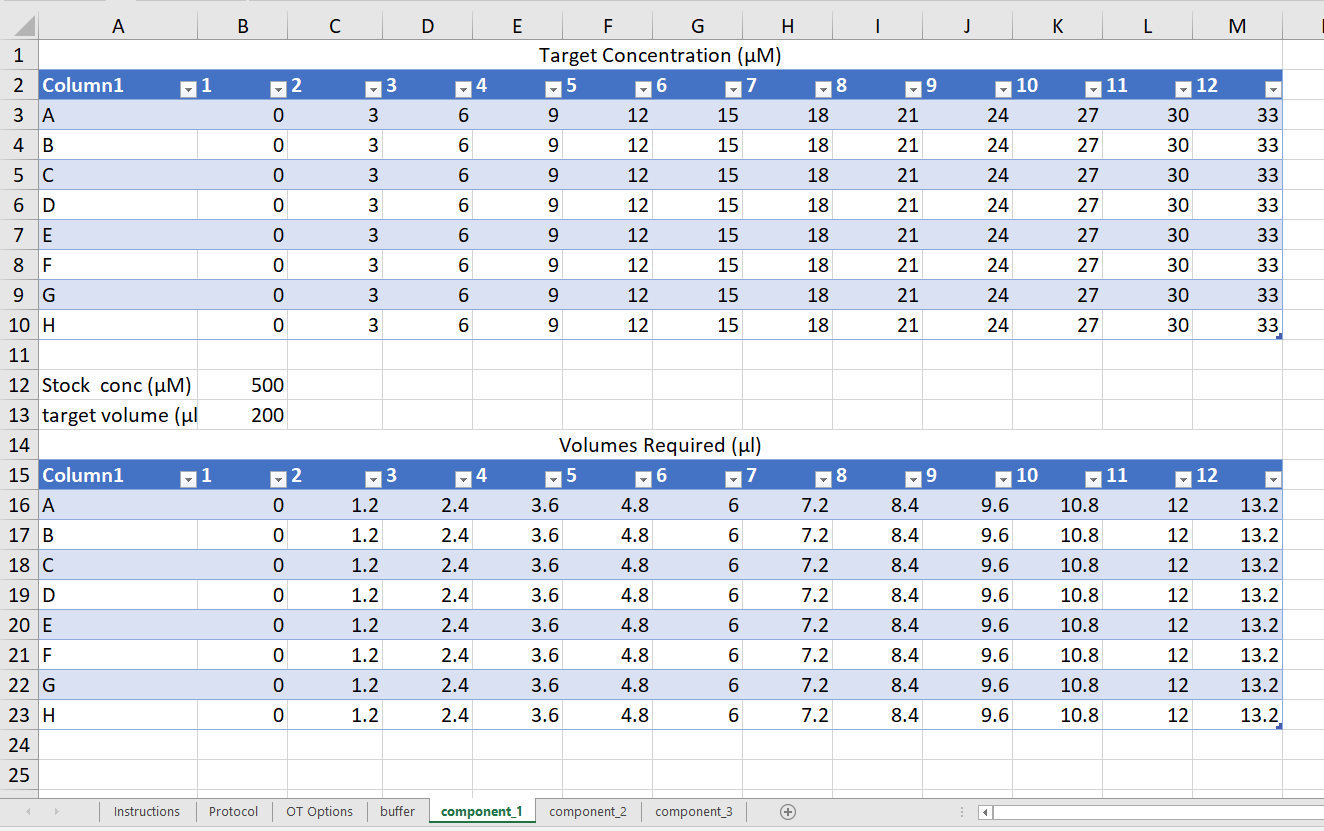

### 2. Import all necessary packages

In [ ]:
import openpyxl
import pandas as pd
from opentrons import simulate, protocol_api, execute
import sys
import io
import os
import numpy as np
!systemctl start opentrons-robot-server

### 3. Extract the protocol information from the excel file

In [ ]:
def read_excel_table(filename, sheet_name, start_row, end_row):
    workbook = openpyxl.load_workbook(filename)
    sheet = workbook[sheet_name]
    
    table_data = []
    header_row = sheet[start_row]
    
    # Iterate over the rows within the specified range
    for row in sheet.iter_rows(min_row=start_row+1, max_row=end_row, values_only=True):
        
        if all(value is None for value in row):
            continue
        row_data = {}
        
        for i, value in enumerate(row):
            header_cell = header_row[i]
            header = header_cell.value
            if header is not None:
                if header == 'reservoir_well':
                    value = value.split(',')
                    value = [v.strip() for v in value]
                row_data[header] = value
        table_data.append(row_data)
    
    return table_data

# The sheet containing protocol info
sheet_name = 'Protocol'

# Read the wellplate table (rows 1 to 2)
wellplate_info = read_excel_table(filename, sheet_name, 1, 2)
well_plate = wellplate_info[0]['wellplate']
well_plate_slot = wellplate_info[0]['wellplate_slot']

# Read the pipette table (rows 4 to 6)
pipette_info = read_excel_table(filename, sheet_name, 4, 6)

# Read the component table (rows 8 onwards until an empty row is encountered)
component_info = read_excel_table(filename, sheet_name, 8, None)

In [ ]:
component_info, pipette_info

### 4. Run the protocol

In [ ]:
def run(protocol: protocol_api.ProtocolContext):
    data = pd.ExcelFile(filename, engine='openpyxl')
    prefix = filename.split('.')[0]
    
    protocol = execute.get_protocol_api('2.8') 
    protocol.home()
    #protocol = simulate.get_protocol_api('2.8') 

    plate = protocol.load_labware(well_plate, well_plate_slot)

    sheet_names = data.sheet_names
    liquids = sheet_names[3:]
    print(f"Order of addition = {liquids}")
    
    # load pipettes

    for pipette_entry in pipette_info:
        pipette_name = pipette_entry['pipette_name']
        pipette_direction = pipette_entry['pipette_mount']
        
        # load tip racks
        tip_racks_list = []

        for i in range(1, 4):
            tip_rack_name = pipette_entry[f'tip_rack_{i}']
            tip_rack_slot = pipette_entry[f'tip_rack_slot_{i}']

            if tip_rack_name != None:
                tip_rack = protocol.load_labware(tip_rack_name, tip_rack_slot)
                tip_racks_list.append(tip_rack)

        # Load the pipette based on the direction
        if pipette_direction == 'left':
            left_pipette = protocol.load_instrument(pipette_name, pipette_direction, tip_racks=tip_racks_list)
            left_pipette_name = pipette_name
        else:
            right_pipette = protocol.load_instrument(pipette_name, pipette_direction, tip_racks=tip_racks_list)
            right_pipette_name = pipette_name

    
    loaded_reservoirs = {}  # Keep track of loaded reservoirs

    for i, sheet_name in enumerate(sheet_names):
        component_sheet = pd.read_excel(data, sheet_name=sheet_name, skiprows=14, usecols='A:M', index_col=0)
        
        for component in component_info:
            component_name = component['component']
            reservoir_name = component['reservoir_name']
            reservoir_slot = component['reservoir_slot']
            reservoir_wells = component['reservoir_well']
            pipette_mount = component['pipette_mount']
            change_tips = component['change_tips']
            delay_mins = component['delay_mins']
            mix_repetitions = component['mix_repetitions']
            mixing_volume = component['mixing_volume']
            tip_aspirate_height = component['aspirate_height']
            tip_dispense_height= component['dispense_height']
            blow_out_height = component['blow_out_height']
            blow_out_option = False
            touch_tip_option = False
            aspirate_speed = component['aspirate_speed']
            dispense_speed = component['dispense_speed']
            mixing_dispense_speed = component['mixing_dispense_speed']
            mixing_aspirate_speed = component['mixing_aspirate_speed']
            touch_tip_speed = component['touch_tip_speed']
            blow_out_speed = component['blow_out_speed']
        
            if component['blow_out'] == 'yes':
                blow_out_option = True
                
            if component['touch_tip'] == 'yes':
                touch_tip_option = True
            
            if pipette_mount == 'left':
                pipette = left_pipette
                pip_name = left_pipette_name
            else:
                pipette = right_pipette
                pip_name = right_pipette_name
                
            if component_name == sheet_name:
                reservoir_key = (reservoir_name, reservoir_slot)
                if reservoir_key not in loaded_reservoirs:
                    loaded_reservoirs[reservoir_key] = protocol.load_labware(reservoir_name, reservoir_slot)
                reservoir = loaded_reservoirs[reservoir_key]
                
                # delay time between component transfers
                if delay_mins > 0:
                    protocol.delay(minutes=delay_mins)
                
                if change_tips == 'Once at the start of step' and not pipette.has_tip: 
                    pipette.pick_up_tip()
                    

                source_wells = reservoir_wells  # Get all wells in the reservoir
                current_well_index = 0  # Track the current source well index

                for row_label in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
                    column_names = list(component_sheet.columns)
                    for col_label in column_names:
                        well = row_label + str(col_label)
                        volume = component_sheet.loc[row_label][col_label]

                        if volume != 0 and volume is not None:  

                            # Transfer from the current source well
                            source_well = source_wells[current_well_index]
                            
                            # multichannel pipettes
                            if 'multi' in pip_name:
                                if row_label == 'A':
                                    if change_tips == 'Before every aspirate':
                                        pipette.pick_up_tip()
                                    
                                    # transfer speeds
                                    pipette.flow_rate.aspirate = aspirate_speed
                                    pipette.flow_rate.dispense = dispense_speed
                                    
                                    pipette.aspirate(volume, reservoir[source_well].bottom(tip_aspirate_height))
                                    pipette.dispense(volume, plate[well].bottom(tip_dispense_height))
                                    
                                    if mixing_volume > 0:
                                        # mixing speeds
                                        pipette.flow_rate.aspirate = mixing_aspirate_speed
                                        pipette.flow_rate.dispense = mixing_dispense_speed
                                        
                                        pipette.mix(repetitions=mix_repetitions, volume=mixing_volume, location=plate[well].bottom(tip_dispense_height))
                                    if touch_tip_option:
                                        pipette.touch_tip(location=plate[well], speed=touch_tip_speed)
                                    if blow_out_option:
                                        pipette.flow_rate.blow_out = blow_out_speed
                                        pipette.blow_out(location=plate[well].bottom(blow_out_height))
                                    if change_tips == 'Before every aspirate':
                                        pipette.drop_tip()
                            
                            # single channel pipettes
                            else:
                                if change_tips == 'Before every aspirate':
                                    pipette.pick_up_tip()
                                
                                # transfer speeds
                                pipette.flow_rate.aspirate = aspirate_speed
                                pipette.flow_rate.dispense = dispense_speed
                                
                                pipette.aspirate(volume, reservoir[source_well].bottom(tip_aspirate_height))
                                pipette.dispense(volume, plate[well].bottom(tip_dispense_height))

                                if mixing_volume > 0:
                                    # mixing speeds
                                    pipette.flow_rate.aspirate = mixing_aspirate_speed
                                    pipette.flow_rate.dispense = mixing_dispense_speed
                                    
                                    pipette.mix(repetitions=mix_repetitions, volume=mixing_volume, location=plate[well].bottom(tip_dispense_height))
                                if touch_tip_option:
                                    pipette.touch_tip(location=plate[well], speed=touch_tip_speed)
                                if blow_out_option:
                                    pipette.flow_rate.blow_out = blow_out_speed
                                    pipette.blow_out(location=plate[well].bottom(blow_out_height))
                                if change_tips == 'Before every aspirate':
                                    pipette.drop_tip()
                            
                            # use next source well 
                            current_well_index += 1
                            if current_well_index == len(source_wells):
                                current_well_index = 0

                    # drop tip after final transfer
                    if pipette.has_tip:
                        pipette.drop_tip()        

    # Output steps in protocol
    with open(f"steps_{prefix}.txt", "w") as output_file:
        for line in protocol.commands():
            output_file.write(line + "\n")
            print(line)
            
run(protocol = protocol_api.ProtocolContext)

<h1 style="text-align: center;">Testing: checking protocol steps and estimate duration</h1> 

1. Open simulate_automation_OT2.py, enter your file name and save the file.
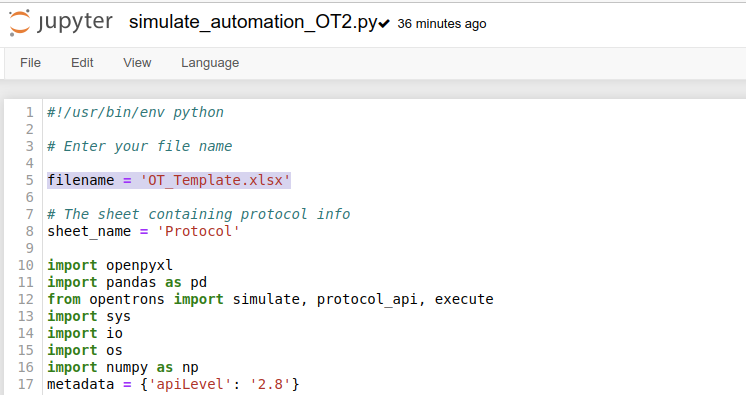
1. Run ```!opentrons_simulate simulate_automation_OT2.py -e``` in a new cell below. If you only want to print the estimated duration, run  ```!opentrons_simulate simulate_automation_OT2.py -e -o nothing```

In [ ]:
!opentrons_simulate simulate_automation_OT2.py -e -o nothing